# Google Play store applications: Performance Analysis


-------------

Data Source: 

Google Play Dataset: https://www.kaggle.com/lava18/google-play-store-apps

-------------

--------

Objective: Finding the determining factors for an apps performance.

--------

e.g. We could find out that pricing is more deterministic of Number of users/rating in Google Play.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import ast

%matplotlib inline

In [2]:

googleDF = pd.read_csv('googleplaystore.csv')
googleReviews = pd.read_csv('googleplaystore_user_reviews.csv')

In [3]:
googleDF.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
googleReviews.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


# Data Cleaning

In [5]:
#Get rid of the '+' in end and remove bad entries (only 2)
googleDF['Installs']=googleDF['Installs'].apply(lambda val: val[:-1]) 

In [6]:
googleDF['Installs'].value_counts()

1,000,000        1579
10,000,000       1252
100,000          1169
10,000           1054
1,000             907
5,000,000         752
100               719
500,000           539
50,000            479
5,000             477
100,000,000       409
10                386
500               330
50,000,000        289
50                205
5                  82
500,000,000        72
1                  67
1,000,000,000      58
0                  14
Fre                 1
                    1
Name: Installs, dtype: int64

In [7]:
googleDF=googleDF[(googleDF['Installs']!='Fre')&(googleDF['Installs']!='')] #Remove the two unusual entries
googleDF['Installs'] = googleDF['Installs'].apply(lambda val: int(val.replace(',','') ) ) # Convert to integer

In [8]:
#Checking Size column where size in 'kB' ONLY
googleDF[googleDF['Size'].apply(lambda val: 'k' in val)].head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
58,Restart Navigator,AUTO_AND_VEHICLES,4.0,1403,201k,100000,Free,0,Everyone,Auto & Vehicles,"August 26, 2014",1.0.1,2.2 and up
209,Plugin:AOT v5.0,BUSINESS,3.1,4034,23k,100000,Free,0,Everyone,Business,"September 11, 2015",3.0.1.11 (Build 311),2.2 and up


In [9]:
"""
If last letter is not 'M' or 'k', then the value is 'Varies with device' which is why we see the 'e'
"""
googleDF['Size'].apply(lambda val: val[-1]).value_counts()



M    8829
e    1694
k     316
Name: Size, dtype: int64

In [10]:
"""
Convert MB to kB
"""
def mB_to_kB(val):
    SCALE=1000
    if('M' in val.upper() and val[-1].upper()=='M'):
        return str(float(val[:-1])*SCALE) + 'k'
    else:
        return val
        
    

In [11]:
#Convert Mb to kB
googleDF['Size']=googleDF['Size'].apply(lambda val: mB_to_kB(val))

In [12]:
"""
'Varies with device' entries were not searched for and added as it is not the objective of this project.
As the purpose of this is to demonstrate analysis, I discard the 'Varies with device' entries. There are 1694 of them (denoted
by the count of 'e' seen below) but I decided that 9145 apps data with confirmed sizes was sufficient for the 
purpose of this demonstration.
"""
googleDF['Size'].apply(lambda val: val[-1]).value_counts()

k    9145
e    1694
Name: Size, dtype: int64

In [13]:
#Not taking rows with unknown Sizes
googleDF=googleDF[googleDF['Size'] !='Varies with device']

In [14]:
#Converting Sizes to float
googleDF['Size']=googleDF['Size'].apply(lambda val:float(val[:-1]))

In [15]:
"""
Convert to integer all the values that are stored as other types
"""
googleDF['Reviews'] = googleDF['Reviews'].apply(lambda val: ast.literal_eval(val))


In [16]:
googleDF['Price'].apply(lambda val: val[0]=='$').value_counts()

False    8421
True      724
Name: Price, dtype: int64

In [17]:
"""
There are 8421 confirmed values with just 0 as entry. The rest have a $ at start, as confirmed above cell
"""
googleDF['Price'].value_counts().sort_values(ascending=False)

0         8421
$0.99      145
$2.99      114
$1.99       66
$4.99       65
          ... 
$2.56        1
$4.85        1
$74.99       1
$4.60        1
$2.59        1
Name: Price, Length: 87, dtype: int64

In [18]:
"""
Convert Price from string with $ sign to float
"""
def priceConvert(val):
    if(val[0]=='$'):
        return float(val[1:])
    else:
        return float(val)

In [19]:
"""
Matches the string version counts so verified no error here.
"""
googleDF['Price'].apply(lambda val: priceConvert(val)).value_counts().sort_values(ascending=False)

0.00     8421
0.99      145
2.99      114
1.99       66
4.99       65
         ... 
46.99       1
1.20        1
2.90        1
74.99       1
2.59        1
Name: Price, Length: 87, dtype: int64

In [20]:
googleDF['Price'] = googleDF['Price'].apply(lambda val: priceConvert(val))

In [21]:
"""
Numerical values are now read as such for our data frame. We can now have an easier time with Exploratory Data Analysis
"""
googleDF.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000.0,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700.0,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000.0,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800.0,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [22]:
"""
Checking for NaN values. We can ignore the ones in Version numbers since we will not be using those.
"""
googleDF.isna().sum()

App                  0
Category             0
Rating            1416
Reviews              0
Size                 0
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

In [23]:
"""
Replace NaN values with Mean of the rest of the available Rating data

NOTE: ******** The NaN values are simply DISCARDED and googleDF_woNaN is used to do model training to avoid mean bias *****
"""

googleDF_woNaN=googleDF[~googleDF['Rating'].isna()].copy() #Numpy and Pandas use bitwise operators so use '~' instead of 'not' and use '&' instead of 'and'
googleDF_NaN=googleDF[googleDF['Rating'].isna()].copy() 

googleDF['Rating'].fillna(googleDF['Rating'].mean(),inplace=True)

In [24]:
googleDF[~googleDF['Rating'].isna()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.100000,159,19000.0,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.900000,967,14000.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.700000,87510,8700.0,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.500000,215644,25000.0,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.300000,967,2800.0,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10835,FR Forms,BUSINESS,4.173852,0,9600.0,10,Free,0.0,Everyone,Business,"September 29, 2016",1.1.5,4.0 and up
10836,Sya9a Maroc - FR,FAMILY,4.500000,38,53000.0,5000,Free,0.0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.000000,4,3600.0,100,Free,0.0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,4.173852,3,9500.0,1000,Free,0.0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up


# Exploratory Data Analysis


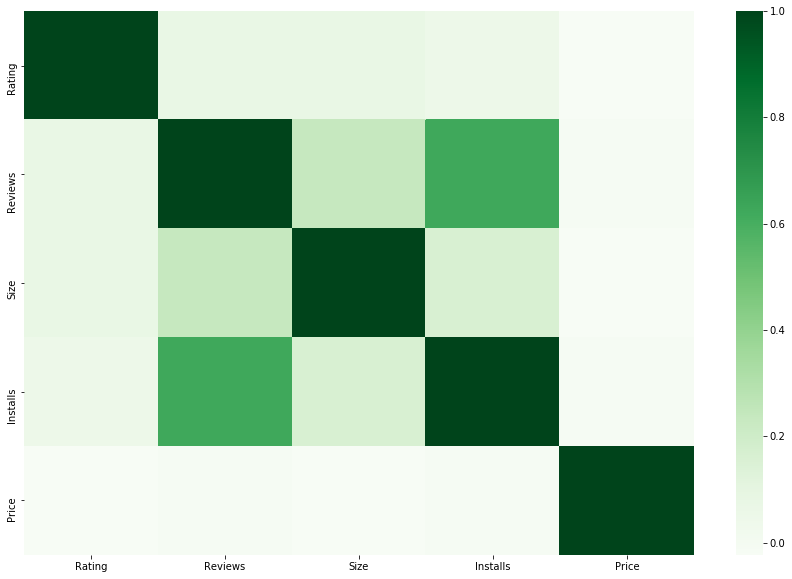

In [25]:
plt.figure(figsize=(15,10))
sns.heatmap(googleDF.corr(),cmap='Greens')

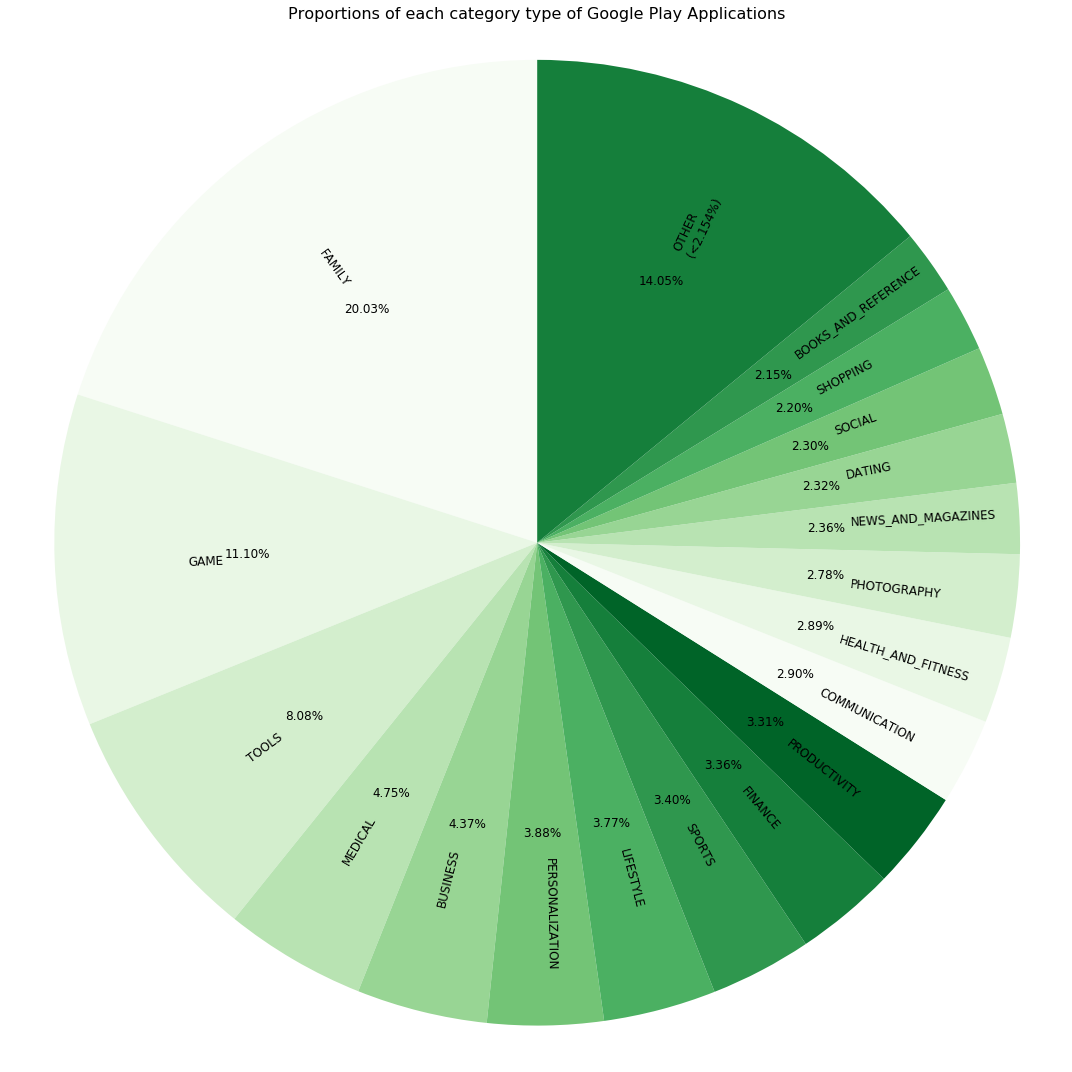

In [26]:
"""
Pie chart for the portions of each category type of applications 
"""
categoryCounts = googleDF['Category'].value_counts().reset_index()
categoryCounts['Percentage of Total']= categoryCounts['Category']/categoryCounts['Category'].sum()

#Change the plt.cm.[thisIsAnyCmapName]...the np.arrange is necessary to generate a certain amount of colors from the cmap
#...play with the numbers for np.arrange to see
#https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
colors = plt.cm.Greens(np.arange(10)/10.)


othersLimit =0.02154

otherCategoriesTotal = categoryCounts[categoryCounts['Percentage of Total']<othersLimit]['Category'].sum()
otherCategoriesPct = categoryCounts[categoryCounts['Percentage of Total']<othersLimit]['Percentage of Total'].sum()



categoryCountsWothers= categoryCounts[categoryCounts['Percentage of Total']>=othersLimit].copy()

#Adding row of 'Others' categories
categoryCountsWothers.loc[categoryCountsWothers.index.max()+1] = ['OTHER\n(<'+str(othersLimit*100)+'%)',otherCategoriesTotal,otherCategoriesPct]


#Plotting Pie Chart
plt.figure(figsize=(15,15))
plt.title('Proportions of each category type of Google Play Applications',fontsize=16)
plt.pie(categoryCountsWothers['Category'],labels=categoryCountsWothers['index'],shadow=False,startangle=90,autopct='%2.2f%%',
       rotatelabels=True,labeldistance=0.65, textprops={'fontsize': 12,'color':'black'}, colors=colors)
plt.axis('equal')

plt.tight_layout()
plt.show()


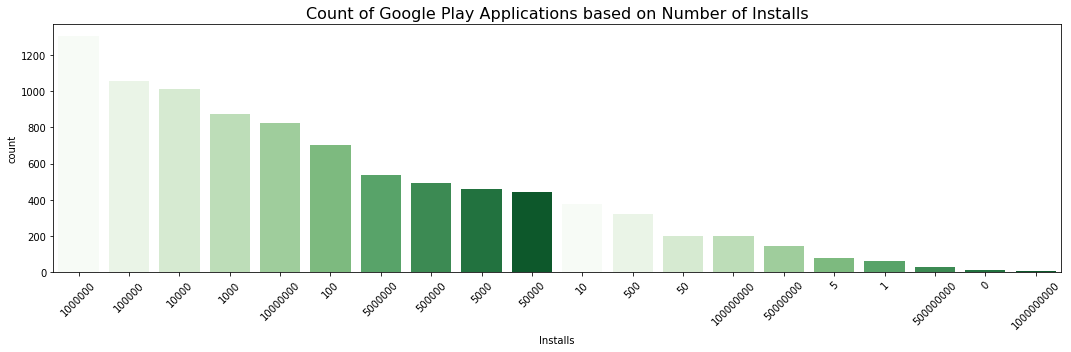

In [27]:
#***SEE colors VARIABLE DEFINED EARLIER TO KEEP SAME LOOK***

plt.figure(figsize=(15,5))
plt.title('Count of Google Play Applications based on Number of Installs',fontsize=16)
sns.countplot(x='Installs',data=googleDF,order = googleDF['Installs'].value_counts().index,
              palette=colors) #SEE colors VARIABLE DEFINED EARLIER TO KEEP SAME LOOK
              
              
              

#Rotating ticks
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

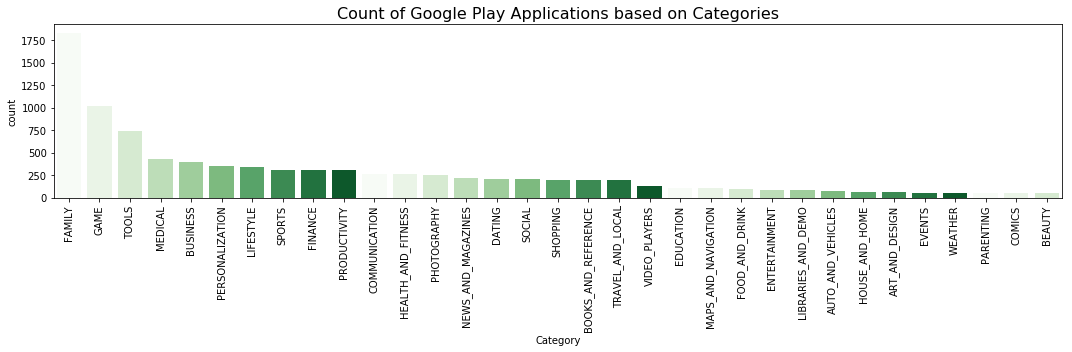

In [28]:


#***SEE colors VARIABLE DEFINED EARLIER TO KEEP SAME LOOK***

plt.figure(figsize=(15,5))
plt.title('Count of Google Play Applications based on Categories',fontsize=16)
sns.countplot(x='Category',data=googleDF, order = googleDF['Category'].value_counts().index,
              palette=colors) #SEE colors VARIABLE DEFINED EARLIER TO KEEP SAME LOOK

#Rotating ticks
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

C:\Users\Humza Wajid\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


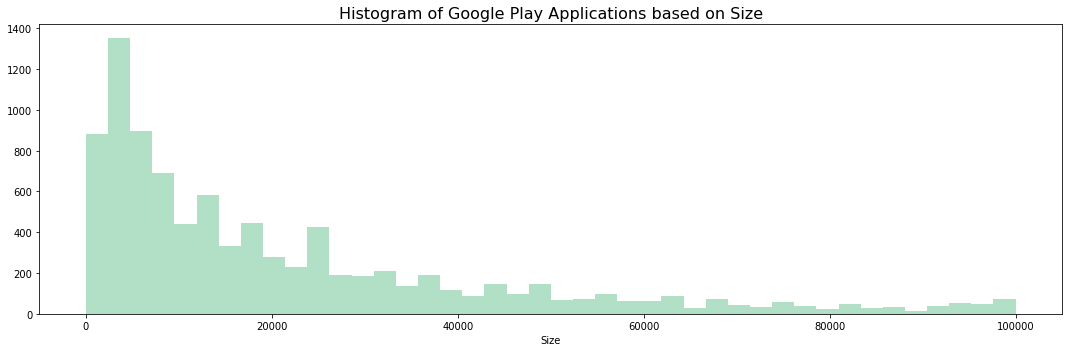

In [29]:
plt.figure(figsize=(15,5))
plt.title('Histogram of Google Play Applications based on Size',fontsize=16)
sns.distplot(googleDF['Size'],kde=False,color='mediumseagreen')


#SAME RESULT USING .hist() .............. unhash the below thing to see
#plt.hist(googleDF['Size'],bins=np.arange(0,101,10),label='Size Histogram',color='brown') 

plt.tight_layout()
plt.show()

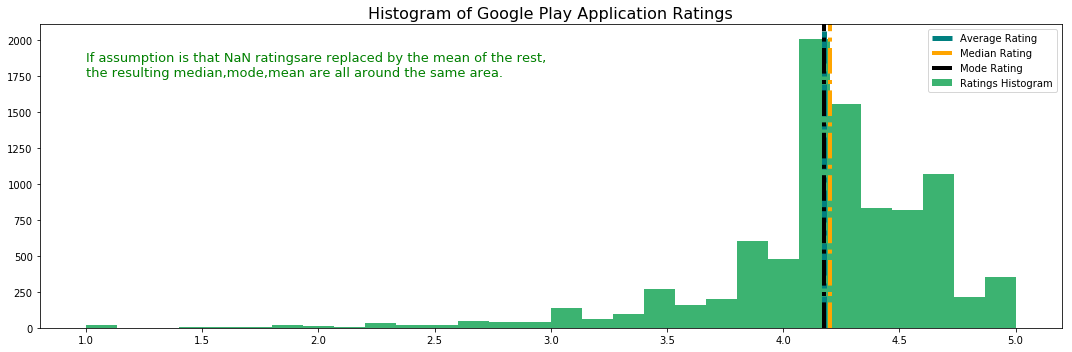

In [30]:
"""
Histogram of Rating. e.g. There are ~1600 Ratings >4.5 and <=5.0
A countplot would be used for Discrete values.
"""


plt.figure(figsize=(15,5))
plt.hist(googleDF['Rating'],bins=30,label='Ratings Histogram',color='mediumseagreen')

avgRating= googleDF['Rating'].mean()
medianRating=googleDF['Rating'].median()
modeRating=googleDF['Rating'].mode()[0] 

plt.axvline(x=avgRating,color='teal',label='Average Rating',linewidth=5,linestyle='dashdot')
plt.axvline(x=medianRating,color='orange',label='Median Rating',linewidth=4,linestyle='dashdot')
plt.axvline(x=modeRating,color='black',label='Mode Rating',linewidth=4,linestyle='dashdot')

plt.title("Histogram of Google Play Application Ratings",fontsize=16)
plt.legend()


#Text explanation:

plt.text(1,1750,"If assumption is that NaN ratings"+
         "are replaced by the mean of the rest,\nthe resulting median,mode,mean are all around the same area.",
        color='green',fontsize=13)

plt.tight_layout()
plt.show()

In [31]:
googleDF.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000.0,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700.0,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000.0,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800.0,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


----------------------------------

The following cell graph shows why a logarithmic (OR OTHER Standardizing Scale) transformation of data may be needed to improve results. There are values with a very big range and frequency of both large and small values are significant. They cannot be considered outliers and there is no reason to separate analysis of apps based on the size so it would be best to keep it together and use a log scale instead.

-----------------------------------


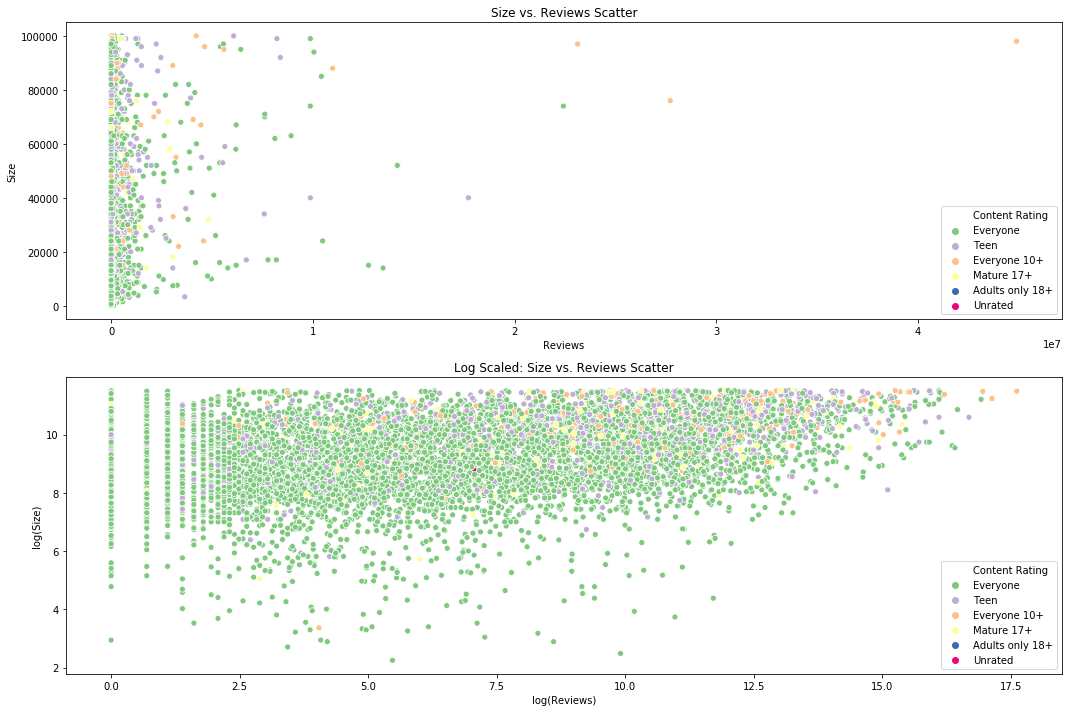

In [32]:
"""
Applying Logarithmic Transformation for large range data(ON BOTH X AND Y AXIS VALUES)
"""

f, axes = plt.subplots(2,1,figsize=(15, 10))




"""
Data BEFORE log transformation
"""
sns.scatterplot(x=googleDF['Reviews'],y=googleDF['Size'],data=googleDF,ax=axes[0],hue='Content Rating',palette='Accent')
axes[0].set_xlabel('Reviews')
axes[0].set_ylabel('Size')
axes[0].set_title('Size vs. Reviews Scatter')
    


"""
log(x+1) of data plotted. We do +1 to deal with values of 0
"""
sns.scatterplot(x=np.log(googleDF['Reviews'] +1),y=np.log(googleDF['Size'] +1),data=googleDF,ax=axes[1],hue='Content Rating',palette='Accent')
axes[1].set_xlabel('log(Reviews)')
axes[1].set_ylabel('log(Size)')
axes[1].set_title('Log Scaled: Size vs. Reviews Scatter')

plt.tight_layout()
plt.show()

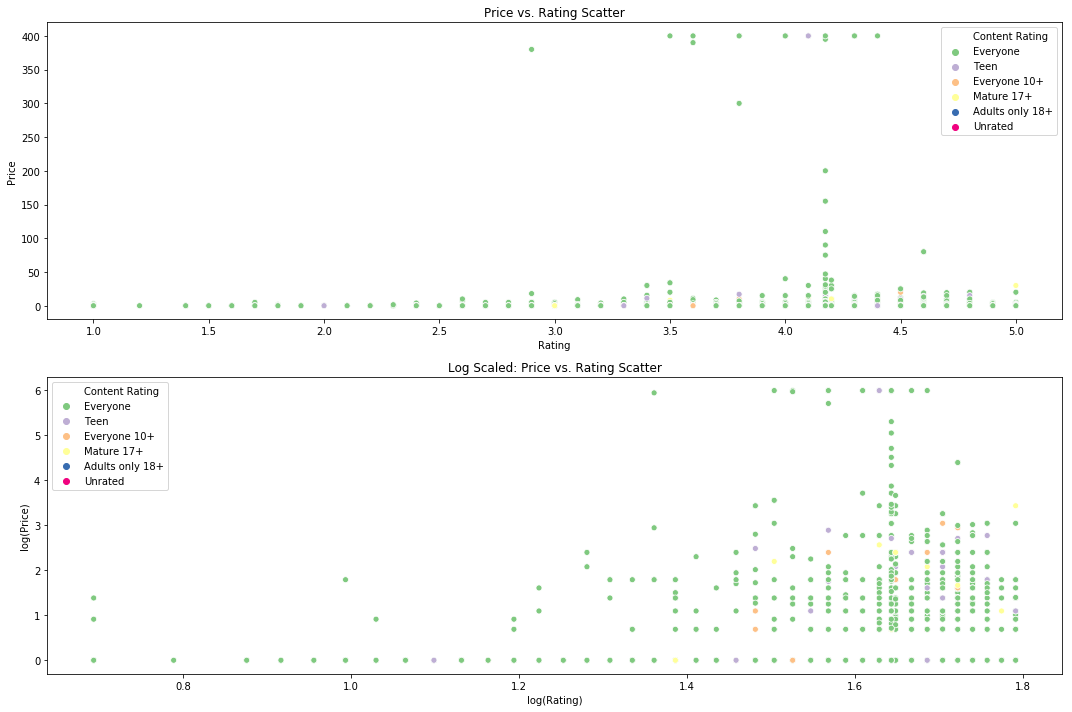

In [33]:
"""
Applying Logarithmic Transformation for large range data(ON BOTH X AND Y AXIS VALUES)
"""

f, axes = plt.subplots(2,1,figsize=(15, 10))




"""
Data BEFORE log transformation
"""
sns.scatterplot(x=googleDF['Rating'],y=googleDF['Price'],data=googleDF,ax=axes[0],hue='Content Rating',palette='Accent')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Price')
axes[0].set_title('Price vs. Rating Scatter')
    


"""
log(x+1) of data plotted. We do +1 to deal with values of 0
"""
sns.scatterplot(x=np.log(googleDF['Rating'] +1),y=np.log(googleDF['Price'] +1),data=googleDF,ax=axes[1],hue='Content Rating',palette='Accent')
axes[1].set_xlabel('log(Rating)')
axes[1].set_ylabel('log(Price)')
axes[1].set_title('Log Scaled: Price vs. Rating Scatter')
    
plt.tight_layout()
plt.show()

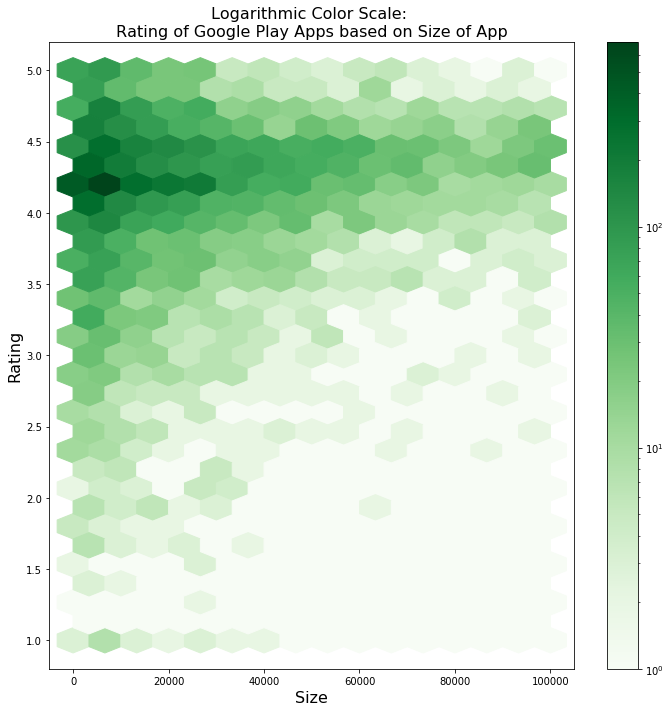

In [34]:
"""
hexbin plot
Using logarithmic scale since very large range of values and without the scale, colors are only one spot of very
light and then rest is completely dark.
"""

plt.figure(figsize=(10,10))
#sns.jointplot(x='Size',y='Rating',data=googleDF,kind='hex',height=10,cmap='viridis')
plt.xlabel('Size',fontsize=16)
plt.ylabel('Rating',fontsize=16)
plt.title('Logarithmic Color Scale: \nRating of Google Play Apps based on Size of App',fontsize=16)

#plt.scatter(x=googleDF['Size'],y=googleDF['Rating'],c='red',s=50,marker='1',kind='hex')
plt.hexbin(x=googleDF['Size'],y=googleDF['Rating'],cmap='Greens',bins='log',gridsize=(15,15))
plt.colorbar()
plt.tight_layout()
plt.show()

# Scikit-Learn Application


In [35]:
"""
Data being used setup. The app versions data are removed since it is not helpful. A column of 'Number of updates since release'
would be much better and helpful since it could explain that apps with a number of updates within a certain range
are more likely to do well.

Data used: Google Play data EXCLUDING rows with NaN entries in Rating column. Taking the mean filled data may be misleading due
to app rating being independent of ratings from all other apps.

"""

#We OMMIT the NaN containing data and do NOT use the data filled with mean values.
print(googleDF_woNaN.columns)
X = googleDF_woNaN[['App', 'Category', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres']].copy()

#Set index to App name

X.set_index('App',inplace=True)


y = googleDF_woNaN['Rating'].copy()


X.head()


Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')


,Category,Reviews,Size,Installs,Type,Price,Content Rating,Genres
App,,,,,,,,
Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,159,19000.0,10000,Free,0.0,Everyone,Art & Design
Coloring book moana,ART_AND_DESIGN,967,14000.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play
"U Launcher Lite – FREE Live Cool Themes, Hide Apps",ART_AND_DESIGN,87510,8700.0,5000000,Free,0.0,Everyone,Art & Design
Sketch - Draw & Paint,ART_AND_DESIGN,215644,25000.0,50000000,Free,0.0,Teen,Art & Design
Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2800.0,100000,Free,0.0,Everyone,Art & Design;Creativity


# Data Preprocessing

Dealing with BOTH MIXED Categorical AND Numerical datarfames : https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

SEE: https://towardsdatascience.com/stop-one-hot-encoding-your-categorical-variables-bbb0fba89809
SEE : https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9

In [36]:
#Used to do actual transformations.(THIS ALSO EXECUTES THE PIPELINE STEPS IN ORDER)
from sklearn.compose import ColumnTransformer

#Creation of Pipelines(Each Pipeline has its own steps. e.g.Fill NaN vals with Mean Then StandardScale them in next step)
from sklearn.pipeline import Pipeline 

#Standardize numerical values and OneHotEncode Categorical vals
from sklearn.preprocessing import StandardScaler, OneHotEncoder 

#For Displaying the Pipeline visually
from sklearn import set_config

#The Regression algorithm we are using 
from sklearn.linear_model import Lasso, LassoCV

#Data split into Training and Test Data
from sklearn.model_selection import train_test_split

from sklearn import metrics

import scipy.sparse

In [37]:

"""
Preprocessing of categorical columns and numerical columns.
--------------------------------
Helpful Sources Used: 
https://stackoverflow.com/questions/58163835/make-regression-model-with-categorical-data-with-scikit-learn
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
--------------------------------


"""


numericalFeatures = ['Reviews', 'Size', 'Installs','Price']

categoricalFeatures = ['Category', 'Type', 'Content Rating', 'Genres']

X_features = googleDF_woNaN[categoricalFeatures+numericalFeatures].copy()
y = googleDF_woNaN['Rating'].copy()


dataPreProcessor = ColumnTransformer(transformers=[
    ('OneHotEncoder', OneHotEncoder(), categoricalFeatures),
    ('StandardScaler', StandardScaler(), numericalFeatures)
], remainder='passthrough')

X = dataPreProcessor.fit_transform(X_features)


X

<7729x157 sparse matrix of type '<class 'numpy.float64'>'
	with 61832 stored elements in Compressed Sparse Row format>

In [38]:
"""
Processed data column names assignment
Retrieving Column Names in APPROPRIATE ORDER. This is important to see which regression components correspond to what.
-------------------------------------

#THIS WILL RETRIEVE IN THE CORRECT ORDER: The names of each column so can replace the number names with actual names of columns
dataPreProcessor.named_transformers_['OneHotEncoder'].categories_

"""


allCatColNames = pd.Series(dataPreProcessor.named_transformers_['OneHotEncoder'].categories_)
encodedColNames = []

for i in range(len(allCatColNames)):
    encodedColNames= encodedColNames + list(allCatColNames[i])

encodedColNames = encodedColNames + numericalFeatures

print("\n\n\n\033[1m"+"Last 4 columns are the Numerical columns(Only Showing 5 rows of data here)\n\n\n--------")
X_processed = pd.DataFrame(X.todense().tolist())

X_processed.columns = encodedColNames

X_processed.head()





Last 4 columns are the Numerical columns(Only Showing 5 rows of data here)


--------


,ART_AND_DESIGN,AUTO_AND_VEHICLES,BEAUTY,BOOKS_AND_REFERENCE,BUSINESS,COMICS,COMMUNICATION,DATING,EDUCATION,ENTERTAINMENT,...,Trivia,Video Players & Editors,Video Players & Editors;Creativity,Video Players & Editors;Music & Video,Weather,Word,Reviews,Size,Installs,Price
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.158077,-0.168811,-0.167701,-0.064805
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.157643,-0.382086,-0.157928,-0.064805
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.111192,-0.608157,-0.068170,-0.064805
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.042418,0.087118,0.829402,-0.064805
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.157643,-0.859820,-0.165906,-0.064805


# Model Training

In [39]:
"""
Data Split, Model Training and Predictions of test data set.


# RESOURCE USED for LassoCV: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html
"""

#Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=0)


#Model Fitting/Training
lassoReg = LassoCV(cv=10, random_state=0,normalize=True)
lassoReg.fit(X_train,y_train)

#Prediction of Test Data
predictions = lassoReg.predict(X_test)


#plt.scatter(y_test,predictions,label=0) 
#plt.legend()

# Model Evaluation

In [40]:
predDF = pd.Series(predictions)
#Reset index since predictions are also reset
y_test.reset_index(drop=True,inplace=True)


actVpred = pd.concat([y_test,predDF],axis=1)
actVpred.columns = ['Actual Rating','Prediction']





"""
Metrics to measure accuracy of results.


"""
sc = lassoReg.score(X_test,y_test)
mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)

print("\033[1m"+
"NOTE: A R^2 value near 0 does NOT necessarily mean the predictions are bad. R^2 being low becomes bad when we are"+
" looking for precision at a very detailed level. In our case, whether a rating is 4.1 or 4.2, we accept this as a good" + 
" rating. Hence,the low R^2 value is not in itself sufficient to discard this model.\n\n")

print('R^2:' + str(sc))
print('MAE:' + str(mae))
print('MSE:' + str(mse))

print("\nMean Squared Error and Mean Absolute Error are small. This is a good indicator of the model."+
     "e.g. The MSE is essential the Sum of Error Squared. A low MSE means overall, the differences with the prediction"
     +" squared are fairly low (close to 0).")

print("\nOnly 10 predictions are shown below for reference.")
actVpred.head(10)

NOTE: A R^2 value near 0 does NOT necessarily mean the predictions are bad. R^2 being low becomes bad when we are looking for precision at a very detailed level. In our case, whether a rating is 4.1 or 4.2, we accept this as a good rating. Hence,the low R^2 value is not in itself sufficient to discard this model.


R^2:0.048650151112372475
MAE:0.3657510785525401
MSE:0.26938916021440024

Mean Squared Error and Mean Absolute Error are small. This is a good indicator of the model.e.g. The MSE is essential the Sum of Error Squared. A low MSE means overall, the differences with the prediction squared are fairly low (close to 0).

Only 10 predictions are shown below for reference.


,Actual Rating,Prediction
0,4.2,4.316022
1,4.4,4.137000
2,3.2,4.131193
3,3.2,4.137030
4,4.4,4.225186
5,2.5,4.020568
6,4.3,4.349203
7,4.3,4.145220
8,4.3,3.967909
9,4.2,4.302502


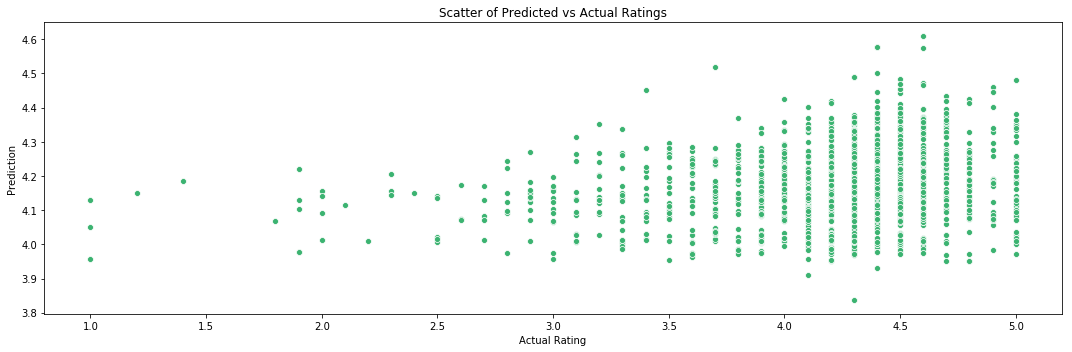

In [41]:

plt.figure(figsize=(15,5))
sns.scatterplot(actVpred['Actual Rating'],actVpred['Prediction'],color='mediumseagreen')
plt.title("Scatter of Predicted vs Actual Ratings")
plt.tight_layout()
plt.plot()
print("")


This could be considered an approximately normally distributed residual plot. This is a good indicator.


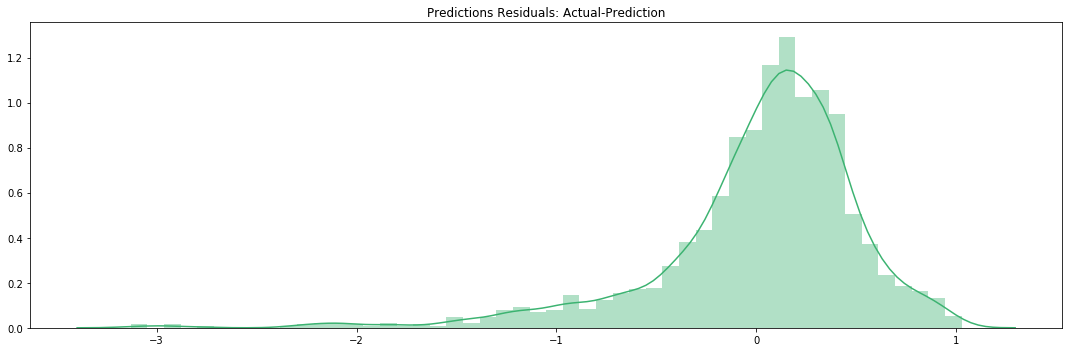

In [47]:

plt.figure(figsize=(15,5))
sns.distplot(actVpred['Actual Rating']-actVpred['Prediction'],bins=50,color='mediumseagreen')
plt.title("Predictions Residuals: Actual-Prediction")
plt.tight_layout()
plt.plot()

print("\033[1m"+"This could be considered an approximately normally distributed residual plot. This is a good indicator.")

The residuals vs actual graph is approximately linear. This is further supporting the linear model used.Although there are clearly some values with bad predictions. Most values are concentrated around residuals of 0, which is a good sign.


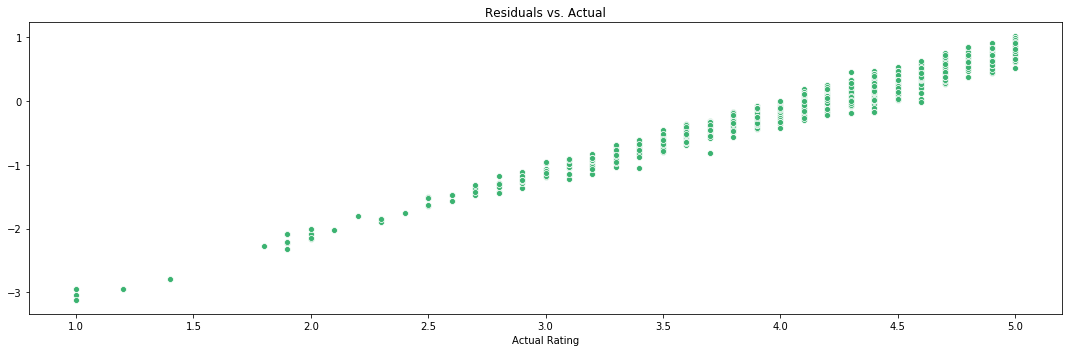

In [43]:

plt.figure(figsize=(15,5))
sns.scatterplot(x=actVpred['Actual Rating'],y=actVpred['Actual Rating']-actVpred['Prediction'],color='mediumseagreen')

plt.title("Residuals vs. Actual")
plt.tight_layout()
plt.plot()

print("\033[1m"+"The residuals vs actual graph is approximately linear. This is further supporting the linear model used."
     +"Although there are clearly some values with bad predictions. Most values are concentrated"+
     " around residuals of 0, which is a good sign.")

The residuals vs predicted graph is within a band of 1 around 0.There are as expected, some values with larger errors, but most are concentrated around 0, which is a positive. The model can be improved, but this attemp serves as a proof of concept of possibilities with ML Algorithms.


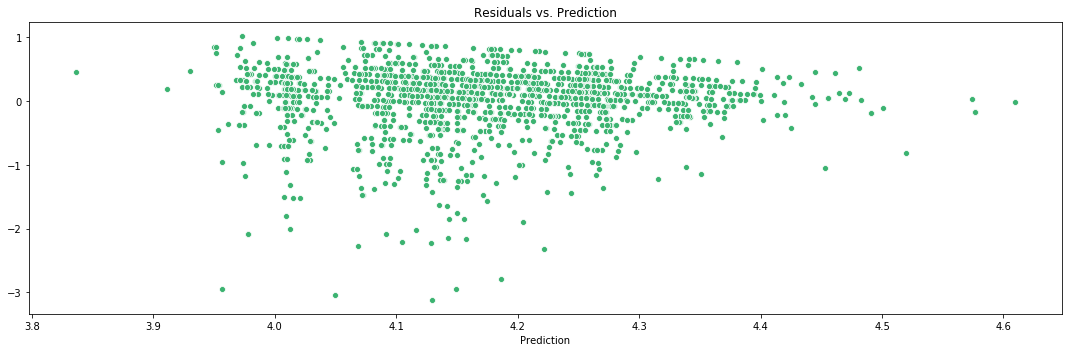

In [44]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=actVpred['Prediction'],y=actVpred['Actual Rating']-actVpred['Prediction'],color='mediumseagreen')

plt.title("Residuals vs. Prediction")
plt.tight_layout()
plt.plot()

print("\033[1m"+"The residuals vs predicted graph is within a band of 1 around 0."
     +"There are as expected, some values with larger errors, but most are concentrated around 0, which is a positive."+
     " The model can be improved, but this attemp serves as a proof of concept of possibilities with ML Algorithms.")

In [45]:
"""
Retrieving coefficients to understand which features were most important in determining app rating

*important Display non-zero coefficients(after converting back and getting the original column names) 
AND *MOST IMPORTANT---- READ LassoCV() and EXPLAIN --> (verify this to be sure): A LassoRegression will automatically 
assign coefficients to the features X (columns) 
depending on level of importance (and 0 if they are useless features). This is why we use LassoRegression 
since we want to explain the most important features that determine the Rating of an application¶
*VERY IMPORTANT OUT OF ALL READ THIS FULLY AND EXPAND ON IT 
"""



coefficientSeries= pd.Series(lassoReg.coef_,index=encodedColNames)
coeffDF = pd.DataFrame(coefficientSeries)
coeffDF.columns=['Coefficients']

print("\n\n\n\033[1m"+"These are the top 50, non zero coefficients along with the app characteristic that defines them."
      +"\ni.e.The ones that have most imapct on the "+
      "rating prediction."
      +"\nThere were " +str(len(coeffDF[coeffDF.iloc[:,0]==0])) +" features that had no impact on the rating.(coeff=0)"+
      "\n--------"
     +"\n\n\n\nCoefficients meaning: The larger the ABSOLUTE value of the coefficient, the larger its impact"
     +"on the rating prediction.")

print("\n\n A negative sign implies that the feature drives DOWN the predicted Rating")
nonZeroCoeff=coeffDF[coeffDF['Coefficients']!=0]

nonZeroCoeff.sort_values(by='Coefficients',ascending=False,key=abs).head(50)




These are the top 50, non zero coefficients along with the app characteristic that defines them.
i.e.The ones that have most imapct on the rating prediction.
There were 41 features that had no impact on the rating.(coeff=0)
--------



Coefficients meaning: The larger the ABSOLUTE value of the coefficient, the larger its impacton the rating prediction.


 A negative sign implies that the feature drives DOWN the predicted Rating


,Coefficients
Comics;Creativity,0.527561
Entertainment;Creativity,0.422449
Books & Reference;Education,0.362614
Puzzle;Education,0.317133
Art & Design;Creativity,0.288322
Strategy;Action & Adventure,0.286814
EVENTS,0.281628
Music;Music & Video,0.279389
Adventure;Brain Games,0.265813
Simulation;Action & Adventure,0.261172


# Conclusion

---------------------------------

A model was produced and can definitely be improved, but this is sufficient for a proof of concept of ML Algorithms and their usefulness. We can conclude that app genres are the most defining component of an apps performance. This is in line with what we would expect. It is perhaps surprising that the numerical components are not as impactful as we would have thought. We also see that the highest coefficients are for creativity and educational apps. This is understandable considering the value there is in being able to create and learn on the go straight off of your smartphone.


This analysis may be improved and expanded upon in time.

---------------------------------
